In [18]:

from pathlib import Path
from netCDF4 import Dataset,chartostring
import numpy as np
import os
import datetime 
import pandas as pd
import matplotlib.pyplot as plt


  


In [2]:
#you need to set these!
WHATPRIOR='na_sword_v16_SOS_priors.nc'
WHATAGENCY='USGS'
WHATFLPE='sic4dvar'
QVAR='Q_da'

In [3]:
RUN=Path('/nas/cee-water/cjgleason/SWOT_Q_UMASS')
SONE=RUN.joinpath('mnt').joinpath('flpe')
TSfiles=RUN.joinpath('mnt').joinpath('input').joinpath('swot')
YOURFLPE=SONE.joinpath(WHATFLPE)
if WHATFLPE == 'sic4dvar':
    YOURFLPE=YOURFLPE.joinpath('reaches')
    


In [4]:

G=RUN.joinpath(WHATPRIOR)
G=Dataset(G)
Grid=G[WHATAGENCY][WHATAGENCY+'_reach_id'][:].filled(np.nan)
yourflpefiles=os.listdir(YOURFLPE)
FLPEr=[]
for filen in yourflpefiles:
    D=Dataset(YOURFLPE.joinpath(filen))
    if any(~np.isnan(D[QVAR][:].filled(np.nan))):
        FLPEr.append(int(filen[0:11]))

OLR=list(set(FLPEr).intersection(set(Grid)))

In [5]:
FLPEQ=[]
ST=[]
GT=[]
GQ=[]
Reach=[]
for REACH in OLR:
    Reach.append(REACH)
    TSfile=Dataset(TSfiles.joinpath(str(REACH)+'_SWOT.nc'))
    ttt=chartostring(TSfile['reach/time_str'][:])
    reachT=[]
    for TIMZ in ttt:
        if TIMZ=='no_data':
            reachT.append(np.nan)
        else:
            reachT.append( datetime.datetime.strptime(TIMZ[0:10],'%Y-%m-%d').toordinal())
        
    ST.append(reachT)
    FLPEf=Dataset(YOURFLPE.joinpath(str(REACH)+'_'+WHATFLPE+'.nc'))
    FLPEQ.append(FLPEf[QVAR][:].filled(np.nan))
    Gindex=np.where(G[WHATAGENCY][WHATAGENCY+'_reach_id'][:].filled(np.nan)==REACH)[0][0]
    GQ.append(G[WHATAGENCY+'/'+WHATAGENCY+'_q'][Gindex].filled(np.nan))
    GT.append(G[WHATAGENCY+'/'+WHATAGENCY+'_qt'][Gindex].filled(np.nan))
        
 


In [6]:
COMPdf=pd.DataFrame()
COMPdf['Reach']=pd.Series(Reach)
COMPdf['ST']=pd.Series(ST)
COMPdf['GT']=pd.Series(GT)
COMPdf['GQ']=pd.Series(GQ)
COMPdf['FLPEQ']=pd.Series(FLPEQ)


In [7]:
indexedgq=[]
st=[]
soneq=[]
rid=[]
for r in range(len(COMPdf.Reach)):
    rdf=COMPdf.loc[r]
    rid.append(rdf.Reach)
    STfilter=~np.isnan(rdf.ST)
    goodst=np.array(rdf.ST)[STfilter]
    goodflpeq=rdf.FLPEQ[STfilter]
    gqindex=[]
    for time in goodst:
        tindex=np.where(rdf.GT[~np.isnan(rdf.GT)].astype(int)==int(time))[0]
        if np.size(tindex)>0:
            gqindex.append(tindex[0])
        else:
            gqindex.append(np.nan)
    
    Ggqindex=~np.isnan(gqindex)
    indexedgq.append(rdf.GQ[~np.isnan(rdf.GT)][np.array(gqindex).astype(int)[Ggqindex]])
    st.append(goodst[Ggqindex])
    soneq.append(goodflpeq[Ggqindex])




/tmp/ipykernel_168197/1330387518.py:20: RuntimeWarning: invalid value encountered in cast
  indexedgq.append(rdf.GQ[~np.isnan(rdf.GT)][np.array(gqindex).astype(int)[Ggqindex]])


In [9]:
fCOMPdf=pd.DataFrame()
fCOMPdf['Reach']=pd.Series(rid)
fCOMPdf['ST']=pd.Series(st)
fCOMPdf['GQ']=pd.Series(indexedgq)
fCOMPdf['FLPEQ']=pd.Series(soneq)

In [15]:
NSEo=[]
Rsqo=[]
KGEo=[]
RMSEo=[]
nRMSEo=[]
nBIASo=[]
rRMSEo=[]
no=[]
reach=[]
for re in range(len(fCOMPdf['Reach'])):
    reach.append(fCOMPdf.loc[re].Reach)
    GQ=fCOMPdf.loc[re]['GQ'][~np.isnan(fCOMPdf.loc[re]['FLPEQ'])]
    SQ=fCOMPdf.loc[re]['FLPEQ'][~np.isnan(fCOMPdf.loc[re]['FLPEQ'])] 
    
   

    # NSE
    top=np.sum((GQ-SQ)**2)
    bottom=np.sum((GQ-np.mean(GQ))**2)
    NSE=1-(top/bottom)
    NSEo.append(NSE)
    #Rsq
    r=np.corrcoef( SQ,GQ)
    r=r[0,1]
    Rsq=r**2
    Rsqo.append(Rsq)
    #KGE
    KGE=1-np.sqrt((r-1)**2 + ((np.std( SQ)/np.std(GQ))-1)**2 +((np.mean(SQ)/np.mean(GQ))-1)**2)  
    KGEo.append(KGE)
    #n
    n=len(GQ)
    no.append(n)
    #RMSE
    RMSE=np.sqrt((np.sum( (SQ - GQ)**2))/n)
    RMSEo.append(RMSE)                
    #nRMSE
    NRMSE=RMSE/np.mean(GQ)
    nRMSEo.append(NRMSE)
    #nBIASo
    BIAS= np.sum(SQ - GQ)/len(GQ)
    nBIAS=BIAS/np.mean(GQ)
    nBIASo.append(nBIAS)
    #rRMSE
    rRMSEo.append(np.sqrt(NRMSE**2-nBIAS**2))
    
STATS=pd.DataFrame()
STATS['reach_id']=pd.Series(reach)
STATS['r2']=pd.Series(Rsqo)
STATS['NSE']=pd.Series(NSEo)
STATS['KGE']=pd.Series(KGEo)
STATS['RMSE']=pd.Series(RMSEo)
STATS['nRMSE']=pd.Series(nRMSEo)
STATS['nBIAS']=pd.Series(nBIASo)
STATS['rRMSE']=pd.Series(rRMSEo)
STATS['n']=pd.Series(no)
STATS

/tmp/ipykernel_168197/1144189100.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  NSE=1-(top/bottom)
/home/scoss_umass_edu/.conda/envs/confluenceSC/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/scoss_umass_edu/.conda/envs/confluenceSC/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/scoss_umass_edu/.conda/envs/confluenceSC/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_168197/1144189100.py:28: RuntimeWarning: invalid value encountered in scalar divide
  KGE=1-np.sqrt((r-1)**2 + ((np.std( SQ)/np.std(GQ))-1)**2 +((np.mean(SQ)/np.mean(GQ))-1)**2)
/home/scoss_umass_edu/.conda/envs/confluenceSC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464:

,reach_id,r2,NSE,KGE,RMSE,nRMSE,nBIAS,rRMSE,n
0,74266800131,0.406626,-1.661947,-0.079879,53.520816,0.676960,-0.561682,0.377874,5
1,74267800071,0.998044,-0.008624,0.096506,272.735468,0.831742,-0.646808,0.522910,4
2,74262700551,0.832109,-0.086034,0.273756,25.996534,0.411686,-0.305696,0.275746,3
3,74267500041,0.991424,-9.371692,-0.313676,8397.671846,0.976334,-0.935402,0.279734,4
4,74266900491,0.760472,-0.361490,0.148508,57.781054,0.669353,-0.526436,0.413399,4
...,...,...,...,...,...,...,...,...,...
104,74266400751,0.416902,-0.591420,-0.089828,32.621308,0.903303,-0.642123,0.635322,6
105,74267800051,1.000000,-0.204790,0.046133,388.361420,0.846336,-0.657606,0.532765,2
106,74262700531,1.000000,0.583576,0.439217,16.792978,0.318667,0.181324,0.262050,2
107,74262800371,0.558768,0.260637,0.162568,35.753927,0.438755,-0.003922,0.438738,9


In [16]:
np.max(STATS.n)
STATS.loc[STATS.n==9]

,reach_id,r2,NSE,KGE,RMSE,nRMSE,nBIAS,rRMSE,n
69,74267300181,0.961518,0.147813,0.484900,3552.441018,0.447196,-0.414470,0.167926,9
85,74268700061,0.993907,0.800824,0.649542,139.650340,0.321797,-0.278381,0.161422,9
107,74262800371,0.558768,0.260637,0.162568,35.753927,0.438755,-0.003922,0.438738,9


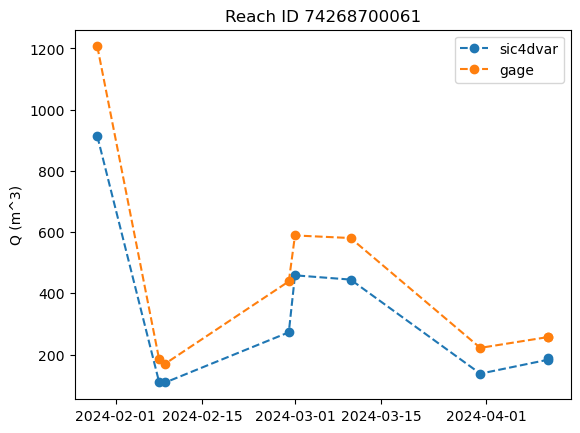

In [29]:
Pindex=85
T=fCOMPdf.loc[Pindex]['ST']
pt=[]
for t in T:
    pt.append(datetime.date.fromordinal(int(t)))
T=pt
S=fCOMPdf.loc[Pindex]['FLPEQ']
G=fCOMPdf.loc[Pindex]['GQ']
plt.plot(T, S,linestyle='--', marker='o', label=WHATFLPE)
plt.plot(T,G,linestyle='--', marker='o', label='gage')
plt.ylabel("Q (m^3)")
plt.title('Reach ID '+ str(fCOMPdf.loc[Pindex].Reach))
plt.legend()